# 1. Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
import plotly.graph_objs as go
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode()
import pickle
import json

# 2. Loading the data

In [2]:
df = pd.read_csv("Credit Card_Clustering.csv")
df.shape

(8950, 18)

👉 The data set contains details of 8,950 credit card holders.

# 3. EDA 🔍

In [3]:
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

👉 In the  dataset all columns are readable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

👉 There are **18 variables** in this data set:
*   **1 categorical** variable (CUST_ID),
*   **14 continuous** variables,
*    **3 discrete numerical** variables

In [5]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [6]:
dist_num_cols=['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']
cont_num_cols=num_cols.symmetric_difference(dist_num_cols)
cont_num_cols

Index(['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE',
       'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES',
       'MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY',
       'PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES', 'PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY'],
      dtype='object')

In [7]:
for col in dist_num_cols:
    print(col, df[col].nunique())

CASH_ADVANCE_TRX 65
PURCHASES_TRX 173
TENURE 7


In [8]:
df[dist_num_cols].describe().T

count       mean        std  min   25%   50%   75%    max
CASH_ADVANCE_TRX  8950.0   3.248827   6.824647  0.0   0.0   0.0   4.0  123.0
PURCHASES_TRX     8950.0  14.709832  24.857649  0.0   1.0   7.0  17.0  358.0
TENURE            8950.0  11.517318   1.338331  6.0  12.0  12.0  12.0   12.0

In [9]:
df[cont_num_cols].describe().T

count         mean          std        min  \
BALANCE                           8950.0  1564.474828  2081.531879   0.000000   
BALANCE_FREQUENCY                 8950.0     0.877271     0.236904   0.000000   
CASH_ADVANCE                      8950.0   978.871112  2097.163877   0.000000   
CASH_ADVANCE_FREQUENCY            8950.0     0.135144     0.200121   0.000000   
CREDIT_LIMIT                      8949.0  4494.449450  3638.815725  50.000000   
INSTALLMENTS_PURCHASES            8950.0   411.067645   904.338115   0.000000   
MINIMUM_PAYMENTS                  8637.0   864.206542  2372.446607   0.019163   
ONEOFF_PURCHASES                  8950.0   592.437371  1659.887917   0.000000   
ONEOFF_PURCHASES_FREQUENCY        8950.0     0.202458     0.298336   0.000000   
PAYMENTS                          8950.0  1733.143852  2895.063757   0.000000   
PRC_FULL_PAYMENT                  8950.0     0.153715     0.292499   0.000000   
PURCHASES                         8950.0  1003.204834  2136.634782   0.000000   
PURCHASES_FREQUENCY               8950.0     0.490351     0.401371   0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY  8950.0     0.364437     0.397448   0.000000   

                                          25%          50%          75%  \
BALANCE                            128.281915   873.385231  2054.140036   
BALANCE_FREQUENCY                    0.888889     1.000000     1.000000   
CASH_ADVANCE                         0.000000     0.000000  1113.821139   
CASH_ADVANCE_FREQUENCY               0.000000     0.000000     0.222222   
CREDIT_LIMIT                      1600.000000  3000.000000  6500.000000   
INSTALLMENTS_PURCHASES               0.000000    89.000000   468.637500   
MINIMUM_PAYMENTS                   169.123707   312.343947   825.485459   
ONEOFF_PURCHASES                     0.000000    38.000000   577.405000   
ONEOFF_PURCHASES_FREQUENCY           0.000000     0.083333     0.300000   
PAYMENTS                           383.276166   856.901546  1901.134317   
PRC_FULL_PAYMENT                     0.000000     0.000000     0.142857   
PURCHASES                           39.635000   361.280000  1110.130000   
PURCHASES_FREQUENCY                  0.083333     0.500000     0.916667   
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000     0.166667     0.750000   

                                          max  
BALANCE                           19043.13856  
BALANCE_FREQUENCY                     1.00000  
CASH_ADVANCE                      47137.21176  
CASH_ADVANCE_FREQUENCY                1.50000  
CREDIT_LIMIT                      30000.00000  
INSTALLMENTS_PURCHASES            22500.00000  
MINIMUM_PAYMENTS                  76406.20752  
ONEOFF_PURCHASES                  40761.25000  
ONEOFF_PURCHASES_FREQUENCY            1.00000  
PAYMENTS                          50721.48336  
PRC_FULL_PAYMENT                      1.00000  
PURCHASES                         49039.57000  
PURCHASES_FREQUENCY                   1.00000  
PURCHASES_INSTALLMENTS_FREQUENCY      1.00000

In [10]:
bounded_cols = []
unbounded_cols=[]
for col in cont_num_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val >= 0 and max_val < 2:
        bounded_cols.append(col)
    else:
        unbounded_cols.append(col)

print("Bounded columns:", bounded_cols)
print("Unbounded columns:", unbounded_cols)

Bounded columns: ['BALANCE_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']
Unbounded columns: ['BALANCE', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES', 'MINIMUM_PAYMENTS', 'ONEOFF_PURCHASES', 'PAYMENTS', 'PURCHASES']


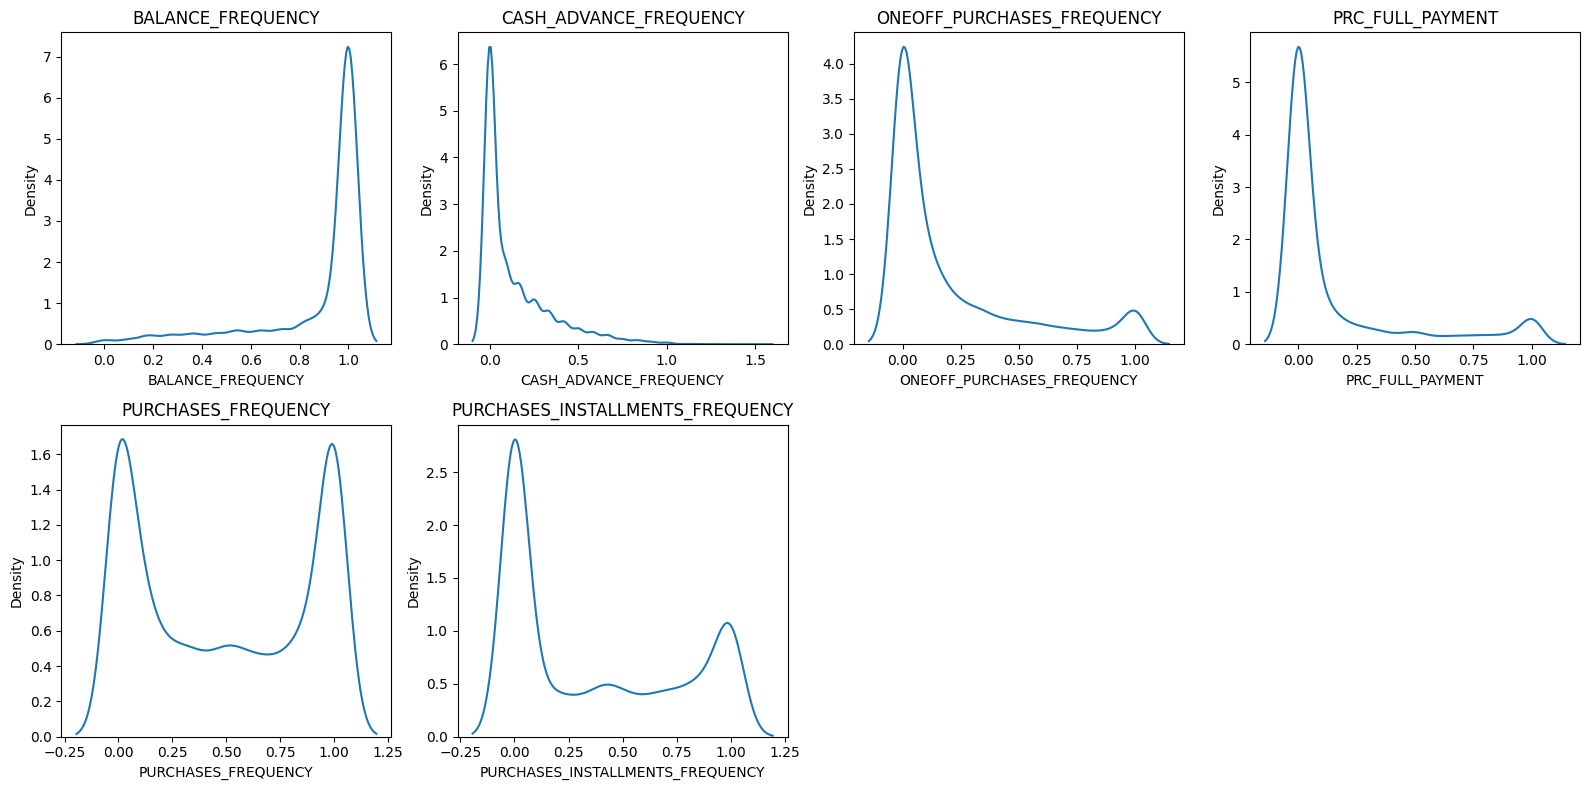

In [11]:
plt.figure(figsize=(16,8))
for i, col in enumerate(bounded_cols, 1):
    plt.subplot(2, 4, i)
    sns.kdeplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

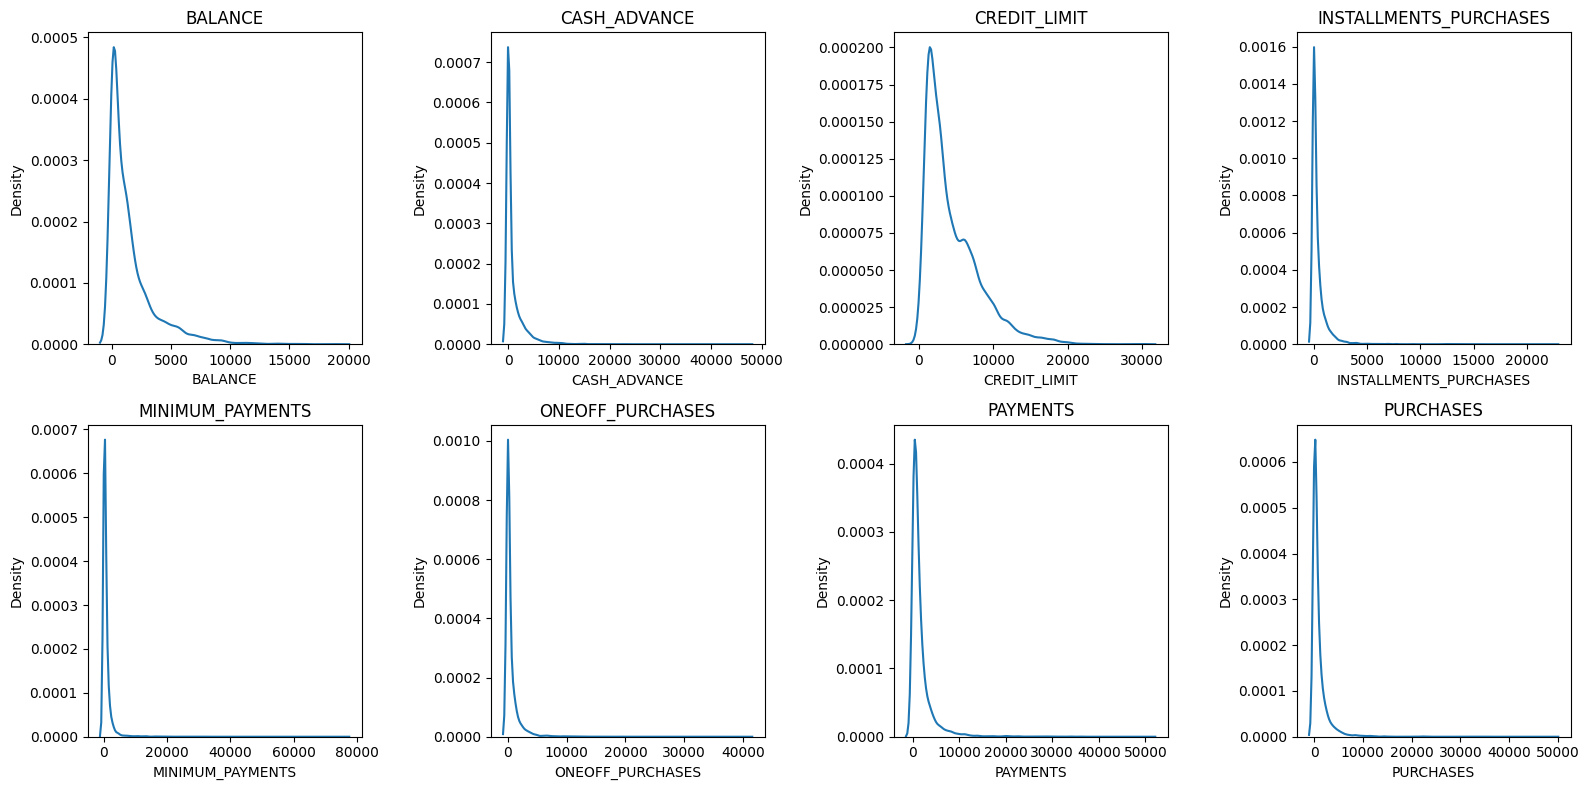

In [12]:
plt.figure(figsize=(16,8))
for i, col in enumerate(unbounded_cols, 1):
    plt.subplot(2, 4, i)
    sns.kdeplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

👉 Here unbounded columns  in the dataset are positively skewed, expected due to a few customers with high transaction amounts.

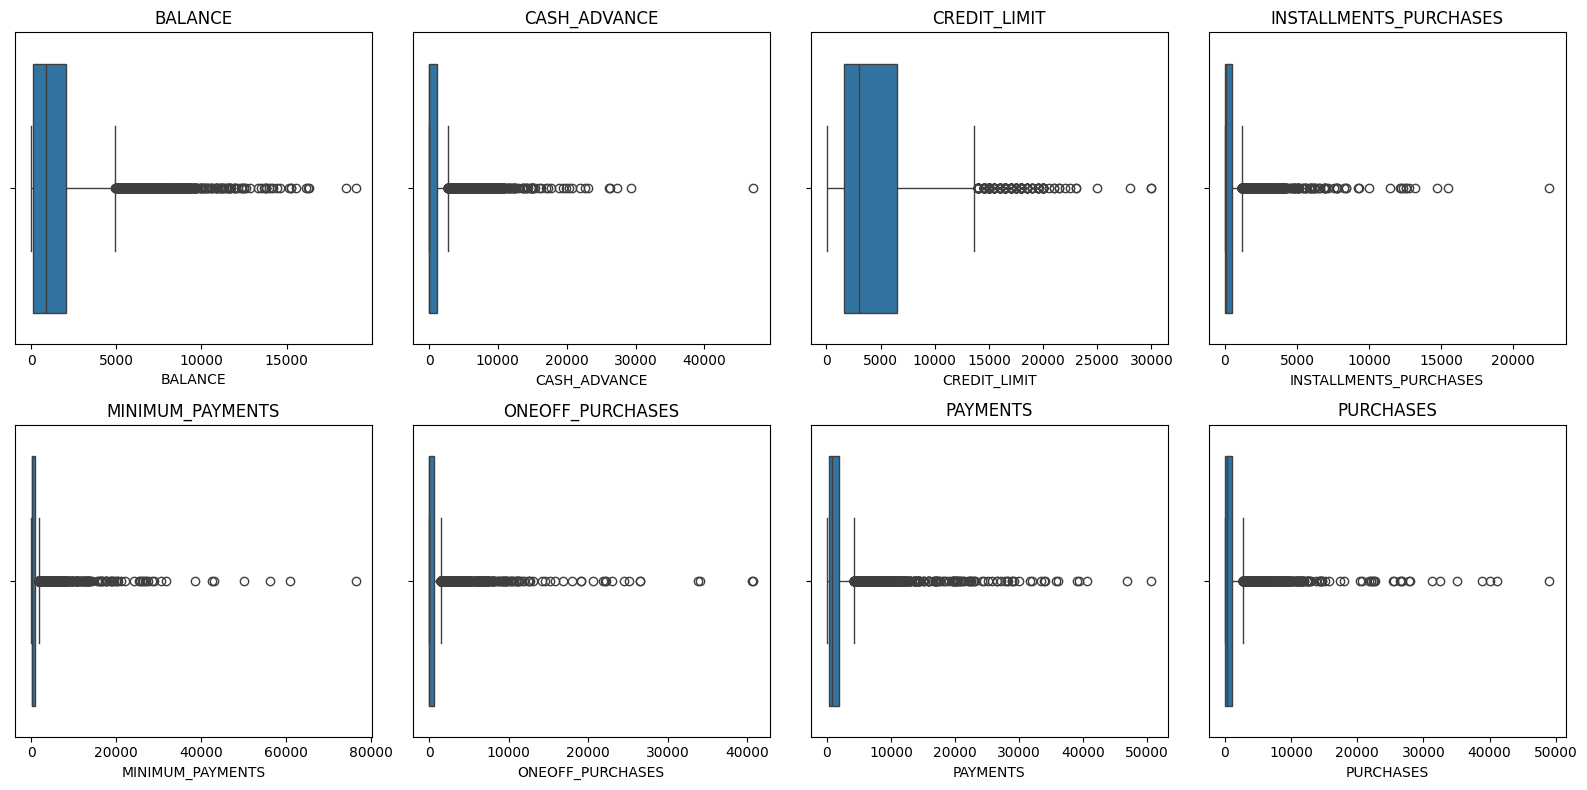

In [13]:
plt.figure(figsize=(16,8))
for i, col in enumerate(unbounded_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

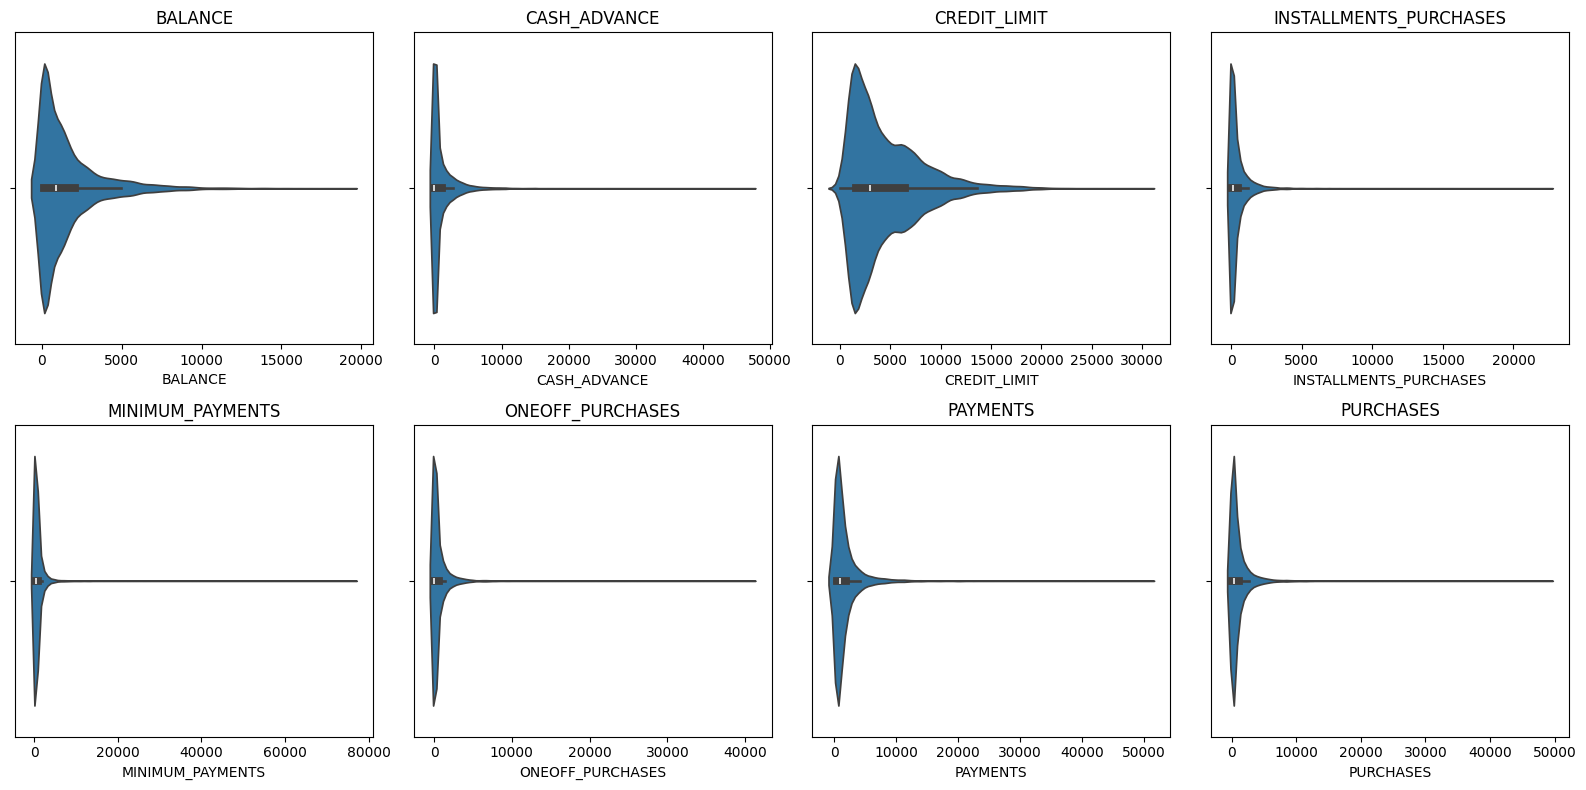

In [14]:
plt.figure(figsize=(16,8))
for i, col in enumerate(unbounded_cols, 1):
    plt.subplot(2, 4, i)
    sns.violinplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [15]:
corr_matrix=df.corr(numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm')

Based on the correlation matrix, here are some pairs with strong correlations (absolute value above 0.6) suggesting potential multicollinearity issues.

* PURCHASES and ONEOFF_PURCHASES: 0.916845
* PURCHASES and PURCHASES_TRX: 0.689561
* ONEOFF_PURCHASES and PURCHASES_TRX: 0.545523
* INSTALLMENTS_PURCHASES and PURCHASES_TRX: 0.628108
* PURCHASES_FREQUENCY and PURCHASES_INSTALLMENTS_FREQUENCY: 0.862934
* CASH_ADVANCE and CASH_ADVANCE_FREQUENCY: 0.628522
* CASH_ADVANCE_FREQUENCY and CASH_ADVANCE_TRX: 0.799561

In [16]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

# 4. Data Preprocessing

Customer ID is unique and won't affect clustering. With only 1 value of CREDIT_LIMIT records having NaN values (just one record), we can drop it without concern. For MINIMUM_PAYMENTS, we can use the median to replace NaN values due to their random nature and the skewed distribution of this feature.

In [17]:
df_new=df.copy()

In [18]:
df_new.drop(['CUST_ID'], axis=1, inplace=True)
columns_to_fill = ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']

for column in columns_to_fill:
    df_new[column].fillna(df_new[column].median(), inplace=True)

## 4.1 Feature Engineering

In [19]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

Since the some columns are not bounded, log transformation will be applied to reduce skewness and normalize their distributions.

In [20]:
df_new = df_new.apply(lambda x: np.log1p(x))

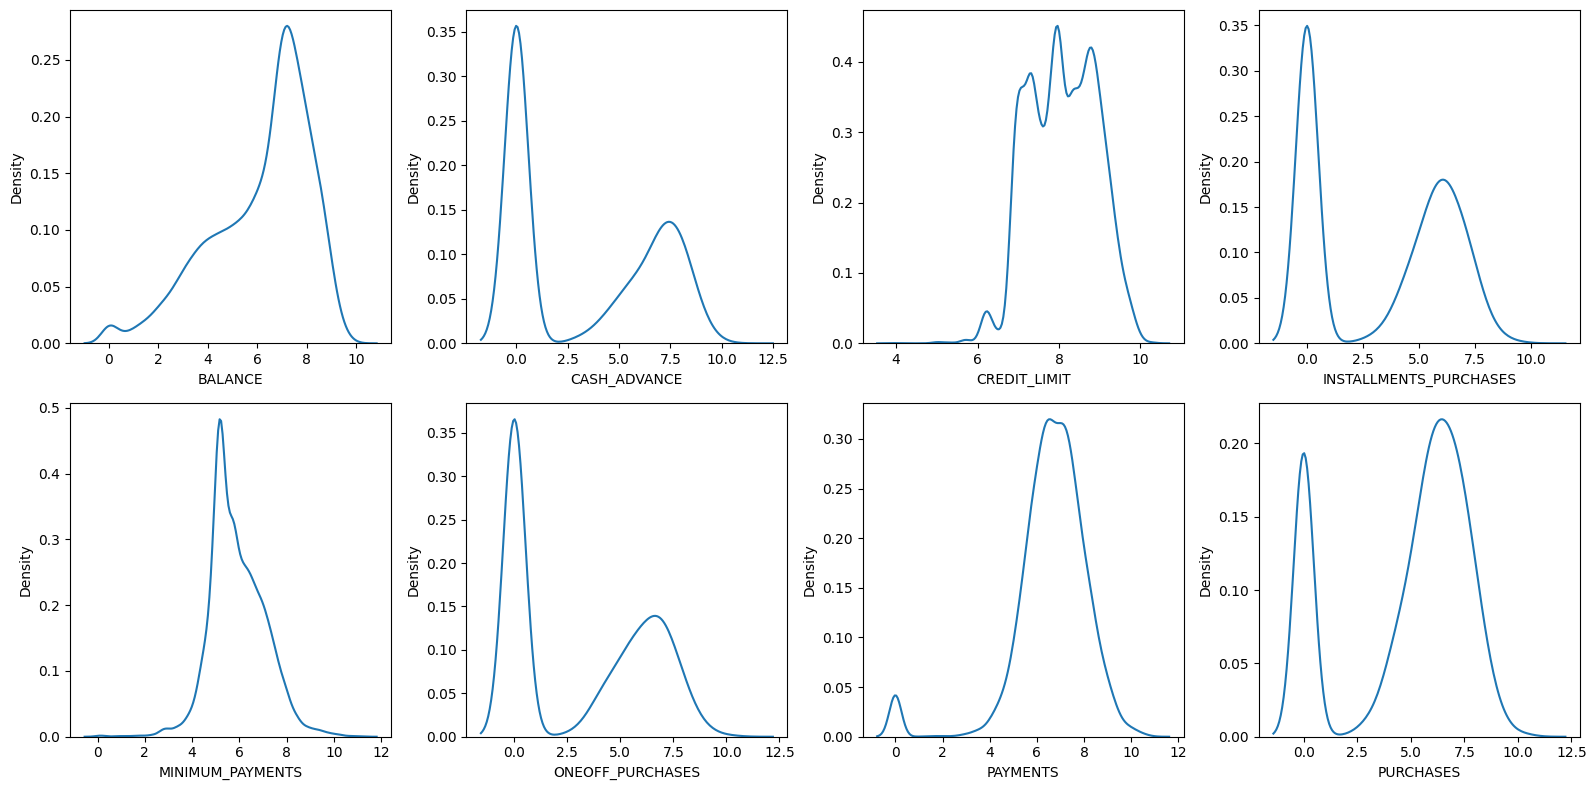

In [21]:
plt.figure(figsize=(16,8))
for i, col in enumerate(unbounded_cols,1):
    plt.subplot(2, 4, i)
    sns.kdeplot(df_new[col])

plt.tight_layout()
plt.show()


In [22]:
corr_matrix=df_new.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

We've identified correlated features and plan to address them through dimensionality reduction using PCA. PCA finds new axes that maximize variance in the data, sequentially selecting components that explain the most variance.

## 4.2 Principal Component Analysis

In [23]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_new), columns=df_new.columns)
print(df_scaled.head())


    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -1.205218          -0.148757  -0.113532         -0.987090   
1  0.948918           0.179616  -1.679855         -0.987090   
2  0.824993           0.492710   0.600727          1.062022   
3  0.624653          -0.857867   0.827499          1.265778   
4  0.271260           0.492710  -0.708481         -0.114307   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                0.394480     -0.930733            -0.746901   
1               -1.087454      1.528788            -1.302799   
2               -1.087454     -0.930733             1.196820   
3               -1.087454      0.564372            -1.014151   
4               -1.087454     -0.930733            -1.014151   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.732480                         -0.674253   
1                   -0.732480                         -0.958256   
2                    2.466762      

In [24]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

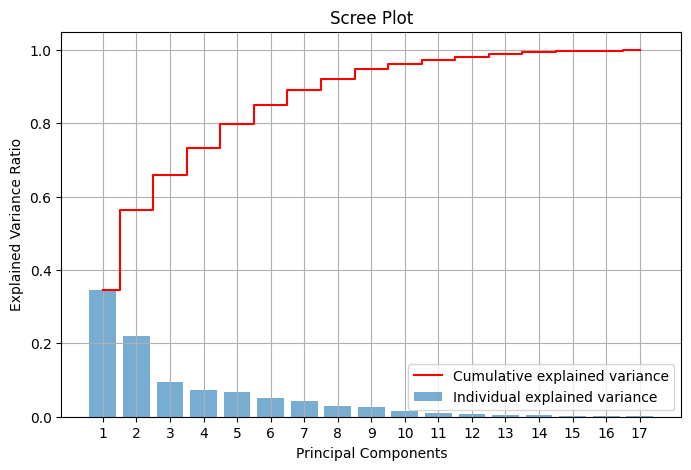

In [25]:
pca_all = PCA(n_components=len(df_scaled.columns), random_state=42)
pca_all.fit(df_scaled)
variance = pca_all.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.bar(range(1, len(variance) + 1), variance, alpha=0.6, align='center', label='Individual explained variance')
plt.step(range(1, len(variance) + 1), np.cumsum(variance), where='mid', label='Cumulative explained variance', color='red')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(range(1, len(variance) + 1))
plt.legend(loc='best')
plt.grid()
plt.show()

In [26]:
print('information extracted from 6 varibles is {} %'.format(np.sum(variance[:6])*100/np.sum(variance)))
print('information extracted from 8 varibles is {} %'.format(np.sum(variance[:8])*100/np.sum(variance)))
print('information extracted from 4 varibles is {} %'.format(np.sum(variance[:4])*100/np.sum(variance)))
print('information extracted from 10 varibles is {} %'.format(np.sum(variance[:10])*100/np.sum(variance)))

information extracted from 6 varibles is 84.98928684506531 %
information extracted from 8 varibles is 92.23363082962722 %
information extracted from 4 varibles is 73.23841477060947 %
information extracted from 10 varibles is 96.29253867386414 %


\Trade-offs:
Dimensionality Reduction: Fewer variables (e.g., 4) might simplify the model, reduce overfitting, and improve interpretability while still capturing a significant amount of variance (73.23%).
Information Retention: More variables (e.g., 10) provide better performance in terms of explained variance (96.29%), but may risk overfitting, especially with smaller datasets.

In [27]:
pca_4 = PCA(n_components=4,  random_state=42)
X_pca_4= pca_4.fit_transform(df_scaled)
X_pca_4

array([[-0.25727393,  2.66163198, -0.31680579, -1.0666064 ],
       [-3.49082055, -1.01569942, -0.05420761, -0.21495693],
       [ 1.46564582, -1.28648248,  2.71985727, -0.91720745],
       ...,
       [ 1.06986433,  3.24748995, -1.78513195,  2.14366724],
       [-2.7815983 ,  3.88666306, -0.49827909,  2.69490368],
       [-0.10513441,  0.57129101,  1.45805312,  3.62346839]])

In [28]:
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_4, f)

# 5. Model Training

In [29]:
import plotly.io as pio
pio.renderers.default = 'colab'

At first glance we can segment with 5 or 6 clusters because it is the most significant decrease, this method is very objective so it will use our perspective by also comparing it with other metrics.

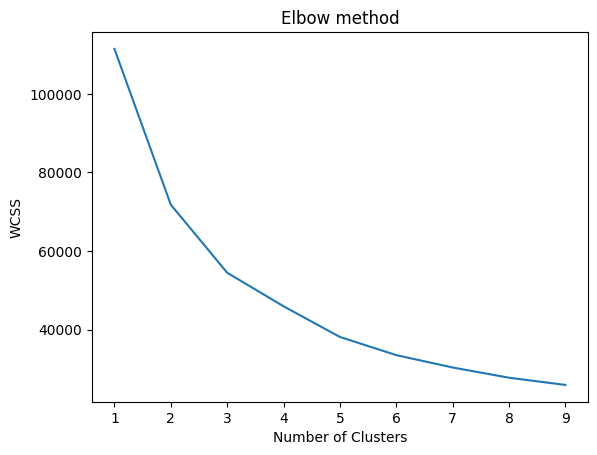

In [31]:
kmeans_models = [KMeans(n_clusters=k, n_init=20, random_state=23).fit(X_pca_4) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

It seems like the elbow is around 5. We will use silhouette score to see which one performs better.

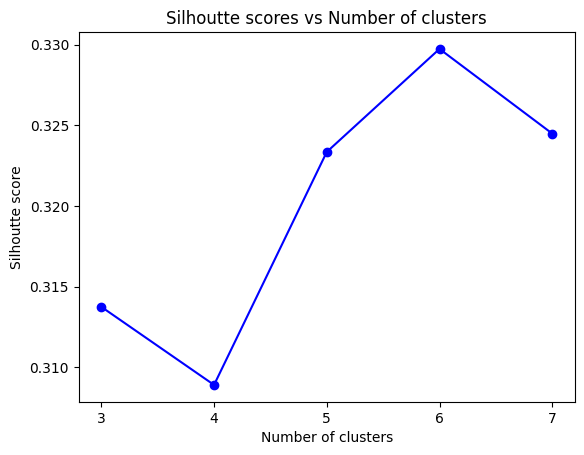

In [32]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(X_pca_4, model.labels_) for model in kmeans_models[2:7]]
plt.plot(range(3,8), silhoutte_scores, "bo-")
plt.xticks([3, 4, 5, 6,7])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

n=6 seems to have a higher silhouette than others.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score
param_grid = {
    'n_clusters': [3, 4, 5,6],
    'max_iter': [200, 300, 500, 1000],
    'tol': [0.1, 0.01, 1e-4, 1e-5, 1e-6],
}
kmeans = KMeans(init ='k-means++', n_init=20, random_state=42)
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(X_pca_4)
best_params=grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Silhouette Score:", grid_search.best_score_)

Best Parameters: {'max_iter': 200, 'n_clusters': 5, 'tol': 0.0001}
Best Silhouette Score: 0.3276548486525822


# 6. Model Evaluation and Inference.

## 6.1 Cluster Visualization (2D)

In [34]:
kmeans = KMeans(**best_params, n_init=20, random_state=42)
kmeans.fit(X_pca_4)
print('Silhoutte score of our model is ' + str(silhouette_score(X_pca_4, kmeans.labels_)))

Silhoutte score of our model is 0.32345628716772684


Assigning labels as cluster index to our dataset.

In [35]:
df_new['cluster_id'] = kmeans.labels_
df_new

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     3.735304           0.597837   4.568506          0.000000   
1     8.071989           0.646627   0.000000          0.000000   
2     7.822504           0.693147   6.651791          6.651791   
3     7.419183           0.492477   7.313220          7.313220   
4     6.707735           0.693147   2.833213          2.833213   
...        ...                ...        ...               ...   
8945  3.384170           0.693147   5.677165          0.000000   
8946  3.004851           0.693147   5.707110          0.000000   
8947  3.194529           0.606136   4.979489          0.000000   
8948  2.671218           0.606136   0.000000          0.000000   
8949  5.923475           0.510826   6.997824          6.997824   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   4.568506      0.000000             0.154151   
1                   0.000000      8.770896             0.000000   
2                   0.000000      0.000000             0.693147   
3                   0.000000      5.331694             0.080042   
4                   0.000000      0.000000             0.080042   
...                      ...           ...                  ...   
8945                5.677165      0.000000             0.693147   
8946                5.707110      0.000000             0.693147   
8947                4.979489      0.000000             0.606136   
8948                0.000000      3.625907             0.000000   
8949                0.000000      4.852343             0.510826   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.080042   
1                       0.000000                          0.000000   
2                       0.693147                          0.000000   
3                       0.080042                          0.000000   
4                       0.080042                          0.000000   
...                          ...                               ...   
8945                    0.000000                          0.606136   
8946                    0.000000                          0.606136   
8947                    0.000000                          0.510826   
8948                    0.000000                          0.000000   
8949                    0.510826                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000          0.000000       1.098612      6.908755   
1                   0.223144          1.609438       0.000000      8.853808   
2                   0.000000          0.000000       2.564949      8.922792   
3                   0.080042          0.693147       0.693147      8.922792   
4                   0.000000          0.000000       0.693147      7.090910   
...                      ...               ...            ...           ...   
8945                0.000000          0.000000       1.945910      6.908755   
8946                0.000000          0.000000       1.945910      6.908755   
8947                0.000000          0.000000       1.791759      6.908755   
8948                0.154151          1.098612       0.000000      6.216606   
8949                0.287682          1.098612       3.178054      7.090910   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  cluster_id  
0     5.312231          4.945277          0.000000  2.564949           3  
1     8.319725          6.978531          0.200671  2.564949           0  
2     6.434654          6.442994          0.000000  2.564949           4  
3     0.000000          5.747301          0.000000  2.564949           3  
4     6.521114          5.504483          0.000000  2.564949           3  
...        ...               ...               ...       ...         ...  
8945  5.788719          3.909748          0.405465  1.945910           1  
8946  5.623517     

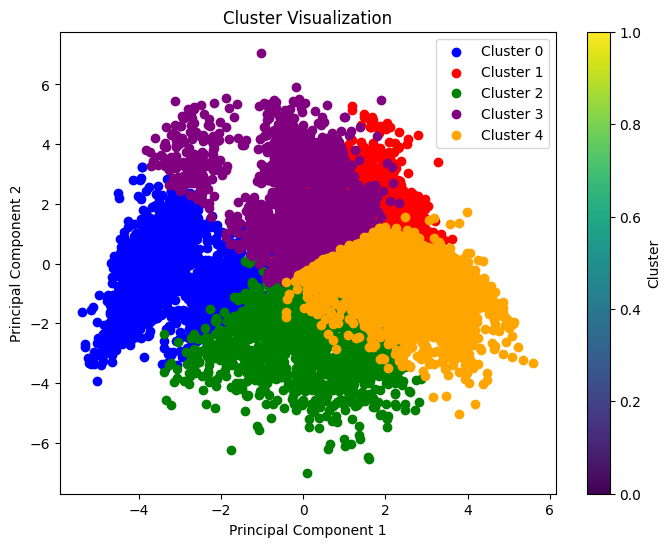

In [36]:
colors = ['blue', 'red', 'green', 'purple', 'orange']
plt.figure(figsize=(8, 6))
for cluster in range(max(df_new['cluster_id']) + 1):
    plt.scatter(X_pca_4[df_new['cluster_id'] == cluster, 0], X_pca_4[df_new['cluster_id'] == cluster, 1],
                color=colors[cluster], label=f'Cluster {cluster}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

## 6.2 3D plot:

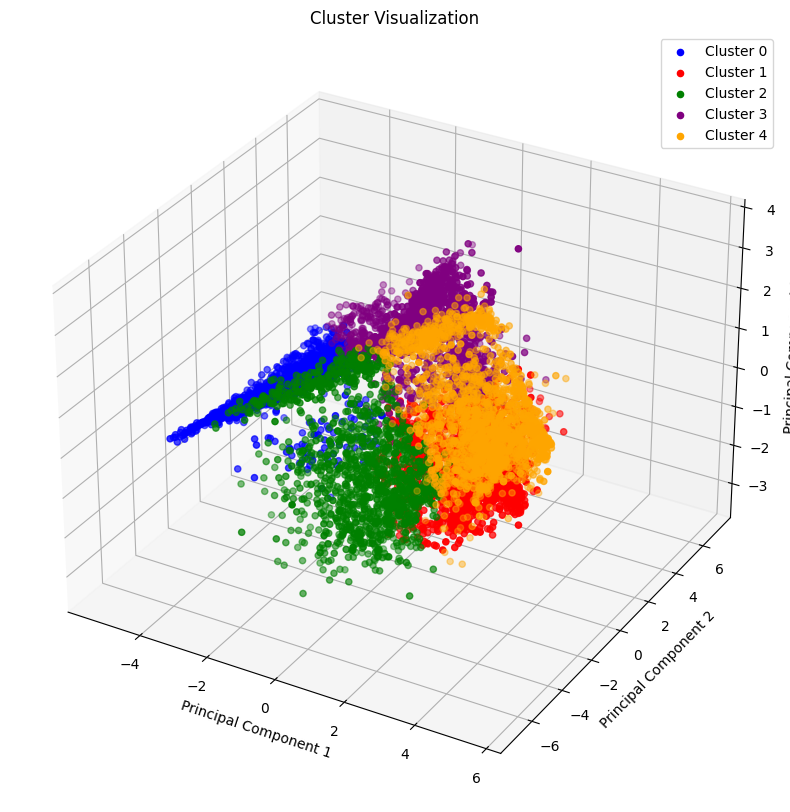

In [37]:
colors = ['blue', 'red', 'green', 'purple', 'orange']
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(max(df_new['cluster_id']) + 1):
    ax.scatter(X_pca_4[df_new['cluster_id'] == cluster, 0],
               X_pca_4[df_new['cluster_id'] == cluster, 1],
               X_pca_4[df_new['cluster_id'] == cluster, 2],
               color=colors[cluster], label=f'Cluster {cluster}')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Cluster Visualization')
ax.legend()
plt.show()

In [38]:
km_clt = KMeans(**best_params, n_init=20, random_state=42)
clusters = km_clt.fit_predict(X_pca_4)
X_pca = pd.DataFrame(X_pca_4, columns=[f'PC{i+1}' for i in range(4)])
X_pca['Clusters'] = clusters

pca = PCA(n_components=3)
X_pca_vis = pca.fit_transform(X_pca)
X_pca_vis = pd.DataFrame(X_pca_vis, columns=['PC1', 'PC2', 'PC3'])
X_pca_vis['Clusters'] = clusters

scatter = []
colors = ['green', 'blue', 'red', 'yellow', 'orange']
for i in range(5):
    cluster_data = X_pca_vis[X_pca_vis['Clusters'] == i]
    scatter.append(go.Scatter3d(
        mode='markers',
        name=f'Cluster {i + 1}',
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        z=cluster_data['PC3'],
        marker=dict(size=2, color=colors[i])
    ))

layout = go.Layout(
    title='3D Scatter Plot of Clusters',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

fig = go.Figure(data=scatter, layout=layout)
fig.show()

In [39]:
import pickle
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(km_clt, f)

## 6.3. Cluster Analysis

In [40]:
df['cluster_id'] = clusters
cluster_0 = df[df['cluster_id'] == 0]
cluster_1 = df[df['cluster_id'] == 1]
cluster_2 = df[df['cluster_id'] == 2]
cluster_3 = df[df['cluster_id'] == 3]
cluster_4 = df[df['cluster_id'] == 4]

In [41]:
need_columns = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']
d={}
for i in need_columns:
    d[i] = pd.DataFrame(df.groupby('cluster_id')[i].describe()[['mean', '50%', 'min', 'max']])

pd.concat(d, axis =1)

BALANCE                                          PURCHASES  \
                   mean          50%        min           max         mean   
cluster_id                                                                   
0           2292.987377  1593.974084  15.523256  14581.459140    37.085804   
1            408.129186    91.618377   0.000000   8115.039014   594.022446   
2           3431.094550  2667.411940  32.779456  16304.889250  1408.133552   
3            296.454316    53.697916   0.000000   4181.216991   329.811143   
4           1479.829692   807.091888   1.198223  19043.138560  2790.585460   

                                      CASH_ADVANCE                    \
                 50%    min       max         mean          50%  min   
cluster_id                                                             
0              0.000   0.00   1770.00  2023.829911  1297.647772  0.0   
1            420.300  12.00  12375.00    40.450529     0.000000  0.0   
2            860.895   4.44  22101.78  2765.844902  1841.720461  0.0   
3            157.400   0.00   3950.00   120.259710     0.000000  0.0   
4           1842.640   8.40  49039.57    55.271454     0.000000  0.0   

                         CREDIT_LIMIT                             PAYMENTS  \
                     max         mean     50%    min      max         mean   
cluster_id                                                                   
0           26194.049540  4120.817617  3000.0   50.0  19000.0  1639.495991   
1            2158.502052  2877.458317  2000.0  300.0  21500.0   743.871521   
2           47137.211760  6001.905488  5000.0  300.0  30000.0  3048.654374   
3            6523.780195  3548.632167  2500.0  150.0  23000.0   769.244496   
4            7894.578816  6226.308587  6000.0  300.0  30000.0  2635.804768   

                                           
                    50%  min          max  
cluster_id                                 
0            791.113474  0.0  34107.07499  
1            496.271288  0.0  15246.11594  
2           1725.428813  0.0  40627.59524  
3            343.102984  0.0  29272.48607  
4           1670.202477  0.0  50721.48336

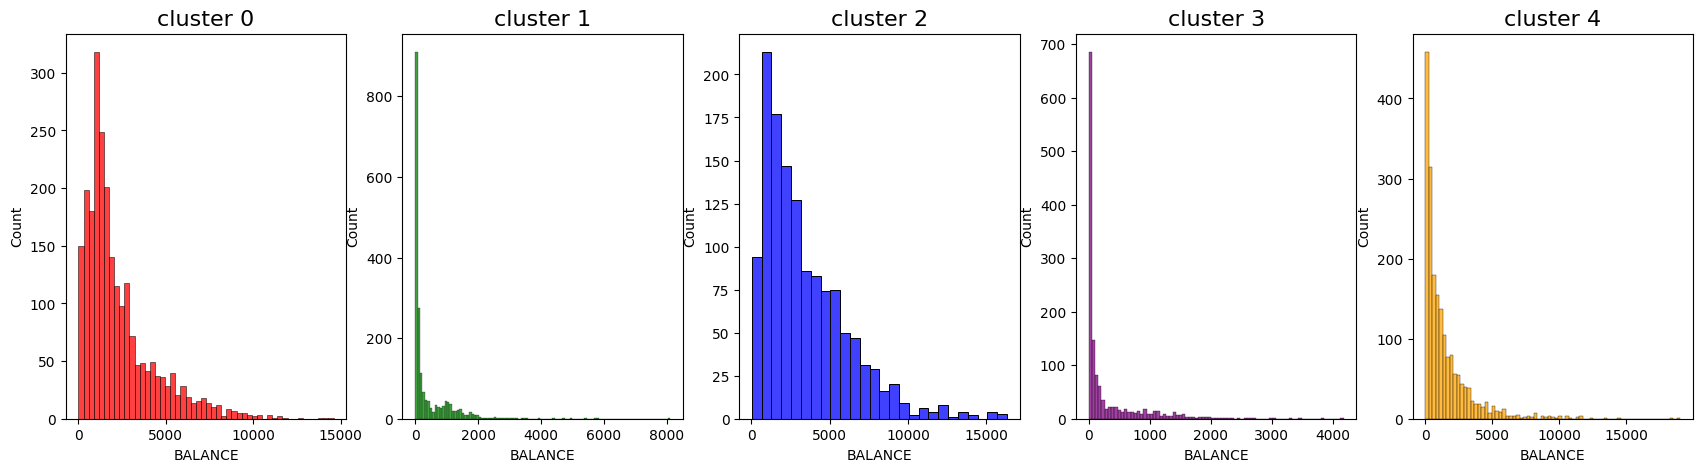

In [42]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['BALANCE'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['BALANCE'], color='green' )
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['BALANCE'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['BALANCE'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['BALANCE'], color='orange')
plt.title('cluster 4', size = 16)
plt.show()

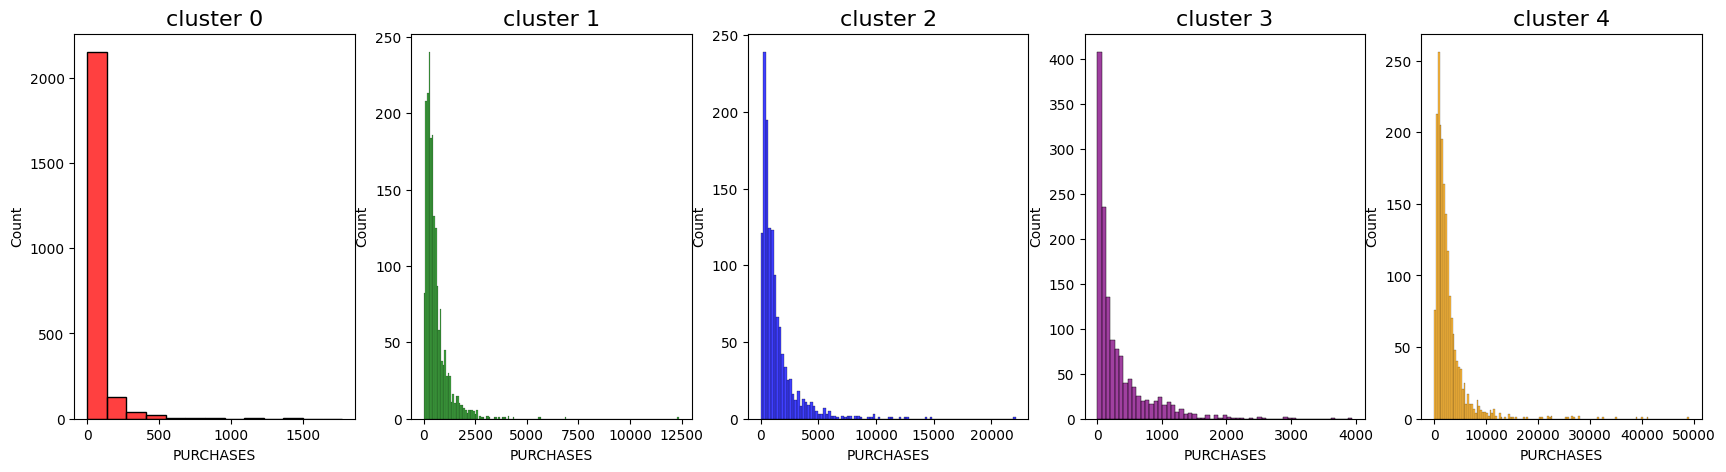

In [43]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['PURCHASES'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['PURCHASES'], color='green' )
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['PURCHASES'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['PURCHASES'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['PURCHASES'], color='orange')
plt.title('cluster 4', size = 16)
plt.show()

Text(0.5, 1.0, 'Purchases Persentage')

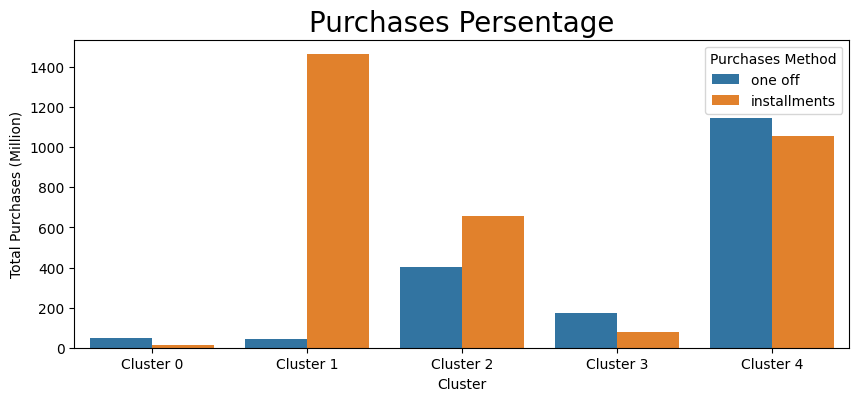

In [44]:
plt.figure(figsize=(10,4))
ax = pd.DataFrame({'Cluster' : ['Cluster 0', 'Cluster 0', 'Cluster 1', 'Cluster 1', 'Cluster 2', 'Cluster 2', 'Cluster 3', 'Cluster 3', 'Cluster 4', 'Cluster 4'],
                    'Purchases' : [cluster_0['ONEOFF_PURCHASES_FREQUENCY'].sum(),
                                   cluster_0['PURCHASES_INSTALLMENTS_FREQUENCY'].sum(),
                                   cluster_1['ONEOFF_PURCHASES_FREQUENCY'].sum(),
                                   cluster_1['PURCHASES_INSTALLMENTS_FREQUENCY'].sum(),
                                   cluster_2['ONEOFF_PURCHASES_FREQUENCY'].sum(),
                                   cluster_2['PURCHASES_INSTALLMENTS_FREQUENCY'].sum(),
                                   cluster_3['ONEOFF_PURCHASES_FREQUENCY'].sum(),
                                   cluster_3['PURCHASES_INSTALLMENTS_FREQUENCY'].sum(),
                                   cluster_4['ONEOFF_PURCHASES_FREQUENCY'].sum(),
                                   cluster_4['PURCHASES_INSTALLMENTS_FREQUENCY'].sum()],
                    'Purchases Method' : ['one off', 'installments', 'one off', 'installments', 'one off', 'installments', 'one off', 'installments', 'one off', 'installments']})
sns.barplot(x='Cluster', y='Purchases', data=ax, hue = 'Purchases Method' )
plt.ylabel('Total Purchases (Million)')
plt.title('Purchases Persentage', size = 20)

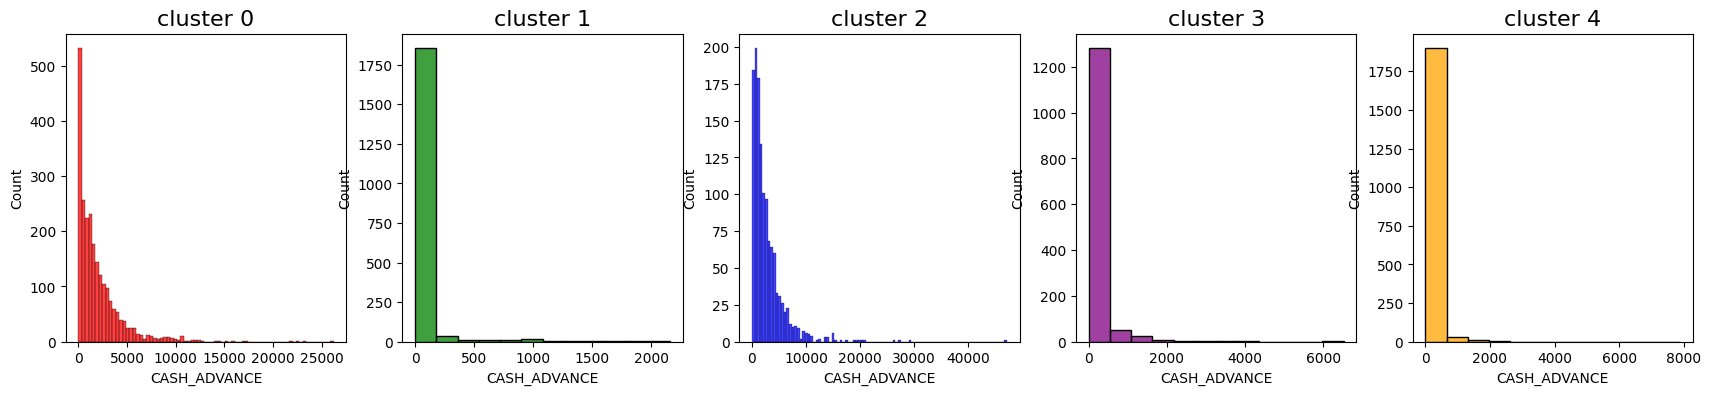

In [45]:
plt.figure(figsize=(21,4))
plt.subplot(1,5,1)
sns.histplot(cluster_0['CASH_ADVANCE'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['CASH_ADVANCE'], color='green' )
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['CASH_ADVANCE'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['CASH_ADVANCE'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['CASH_ADVANCE'], color='orange')
plt.title('cluster 4', size = 16)
plt.show()

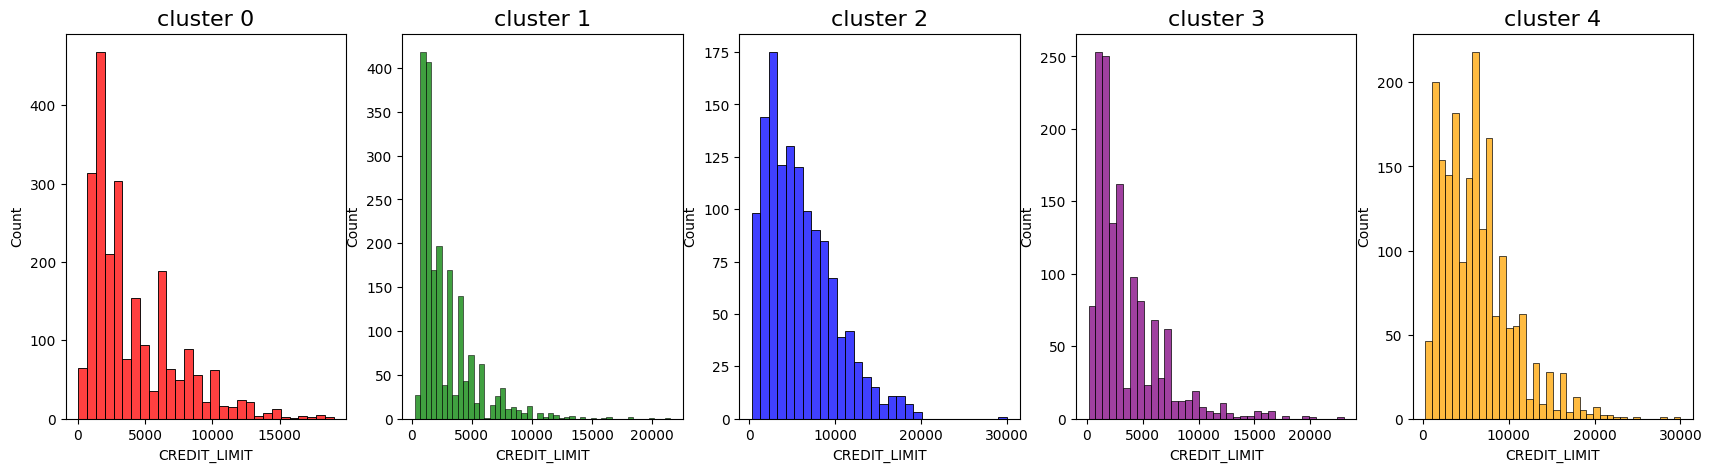

In [46]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['CREDIT_LIMIT'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['CREDIT_LIMIT'], color='green' )
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['CREDIT_LIMIT'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['CREDIT_LIMIT'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['CREDIT_LIMIT'], color='orange')
plt.title('cluster 4', size = 16)
plt.show()

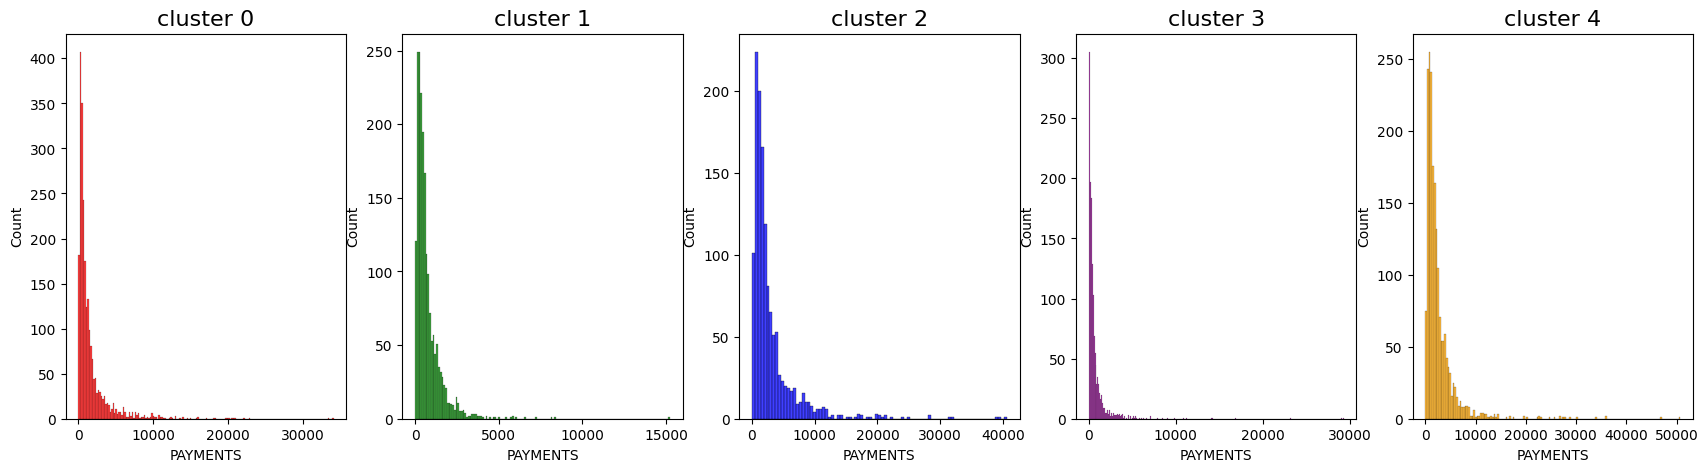

In [47]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['PAYMENTS'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['PAYMENTS'], color='green' )
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['PAYMENTS'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['PAYMENTS'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['PAYMENTS'], color='orange')
plt.title('cluster 4', size = 16)
plt.show()

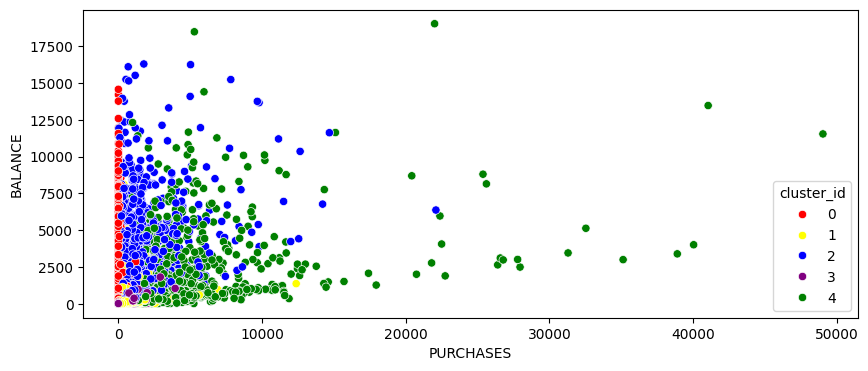

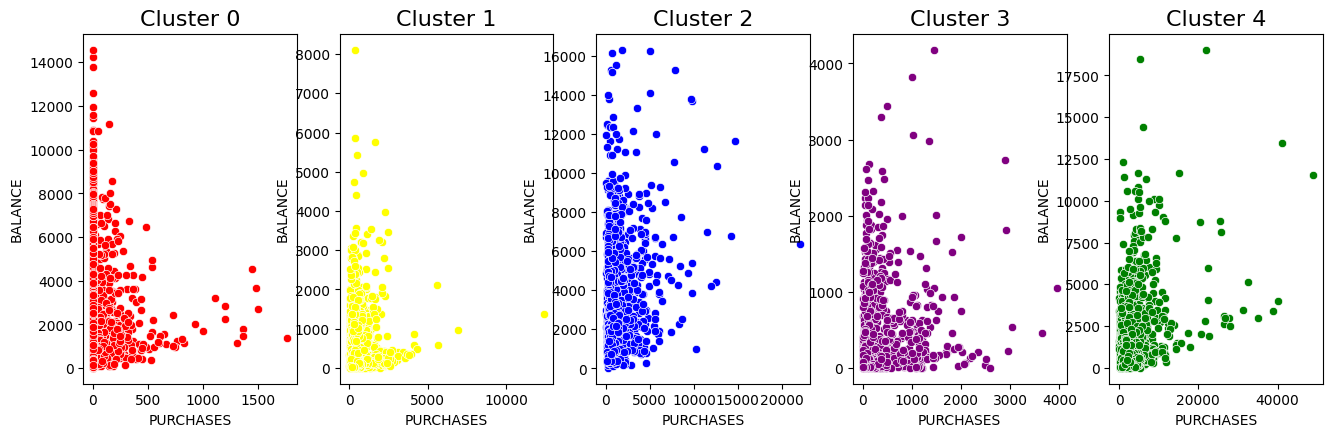

In [48]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='PURCHASES', y='BALANCE', hue='cluster_id', palette=['red', 'yellow', 'blue', 'purple', 'green'])
plt.show()

plt.figure(figsize=(16, 10))

plt.subplot(2, 5, 1)
sns.scatterplot(x=cluster_0['PURCHASES'], y=cluster_0['BALANCE'], color='red')
plt.title('Cluster 0', size=16)

plt.subplot(2, 5, 2)
sns.scatterplot(x=cluster_1['PURCHASES'], y=cluster_1['BALANCE'], color='yellow')
plt.title('Cluster 1', size=16)

plt.subplot(2, 5, 3)
sns.scatterplot(x=cluster_2['PURCHASES'], y=cluster_2['BALANCE'], color='blue')
plt.title('Cluster 2', size=16)

plt.subplot(2, 5, 4)
sns.scatterplot(x=cluster_3['PURCHASES'], y=cluster_3['BALANCE'], color='purple')
plt.title('Cluster 3', size=16)

plt.subplot(2, 5, 5)
sns.scatterplot(x=cluster_4['PURCHASES'], y=cluster_4['BALANCE'], color='green')
plt.title('Cluster 4', size=16)

plt.show()

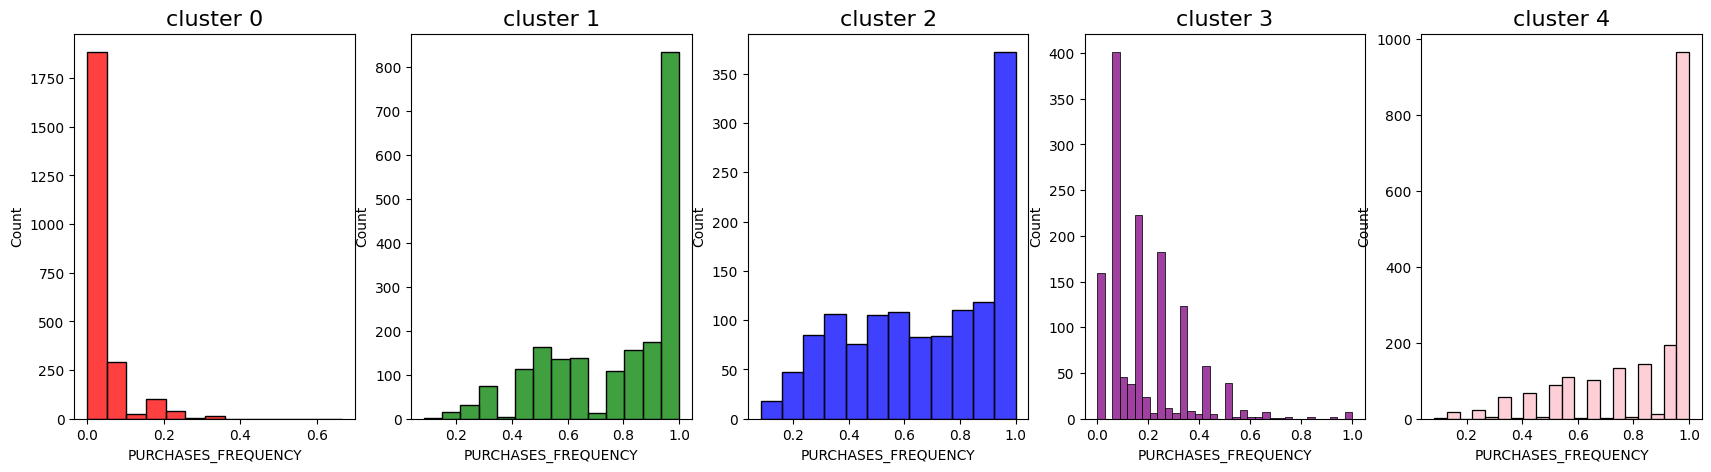

In [49]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['PURCHASES_FREQUENCY'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['PURCHASES_FREQUENCY'], color='green')
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['PURCHASES_FREQUENCY'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['PURCHASES_FREQUENCY'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['PURCHASES_FREQUENCY'], color='pink')
plt.title('cluster 4', size = 16)
plt.show()

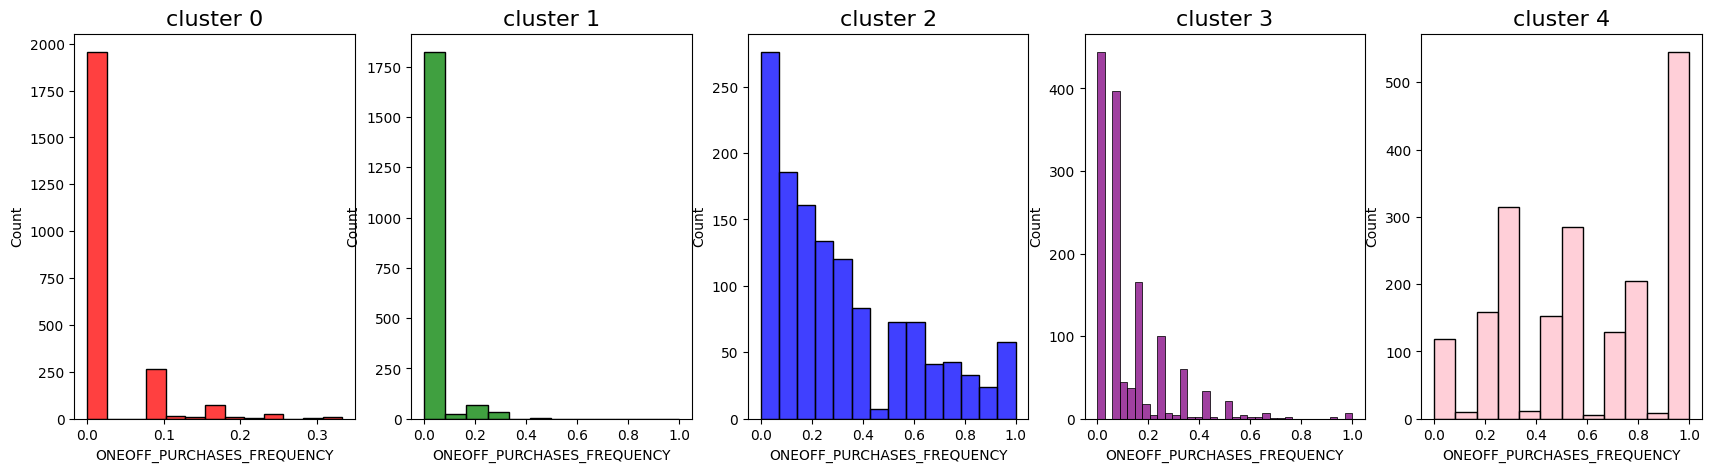

In [50]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['ONEOFF_PURCHASES_FREQUENCY'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['ONEOFF_PURCHASES_FREQUENCY'], color='green')
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['ONEOFF_PURCHASES_FREQUENCY'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['ONEOFF_PURCHASES_FREQUENCY'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['ONEOFF_PURCHASES_FREQUENCY'], color='pink')
plt.title('cluster 4', size = 16)
plt.show()

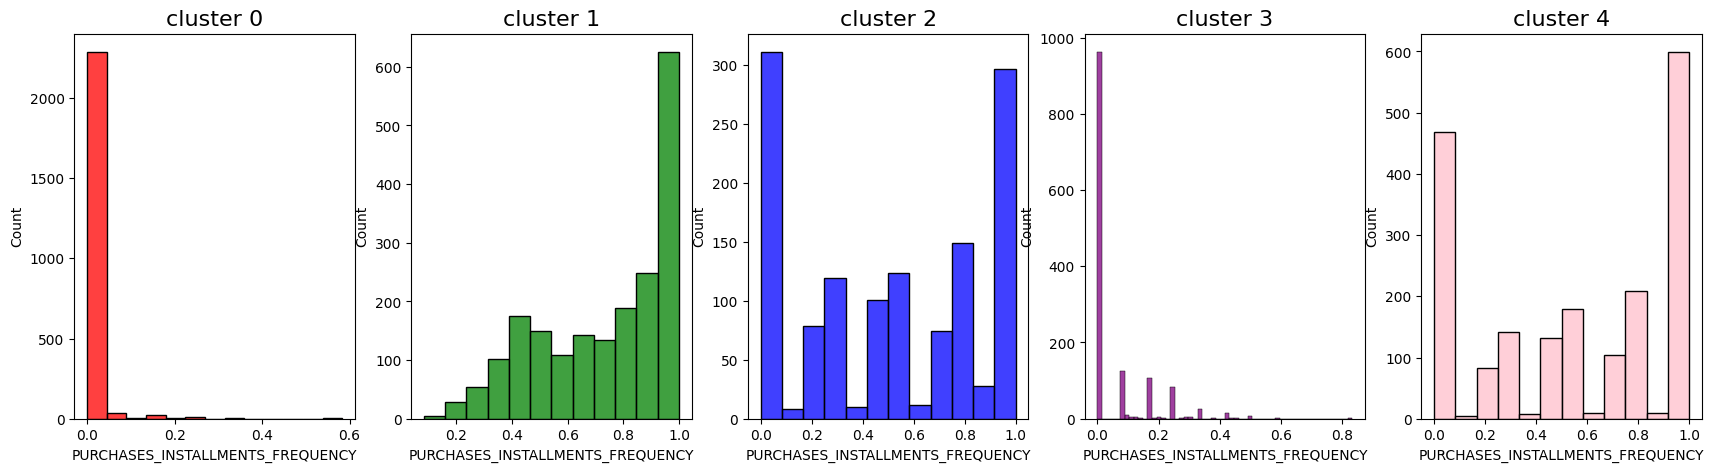

In [51]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['PURCHASES_INSTALLMENTS_FREQUENCY'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['PURCHASES_INSTALLMENTS_FREQUENCY'], color='green')
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['PURCHASES_INSTALLMENTS_FREQUENCY'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['PURCHASES_INSTALLMENTS_FREQUENCY'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['PURCHASES_INSTALLMENTS_FREQUENCY'], color='pink')
plt.title('cluster 4', size = 16)
plt.show()

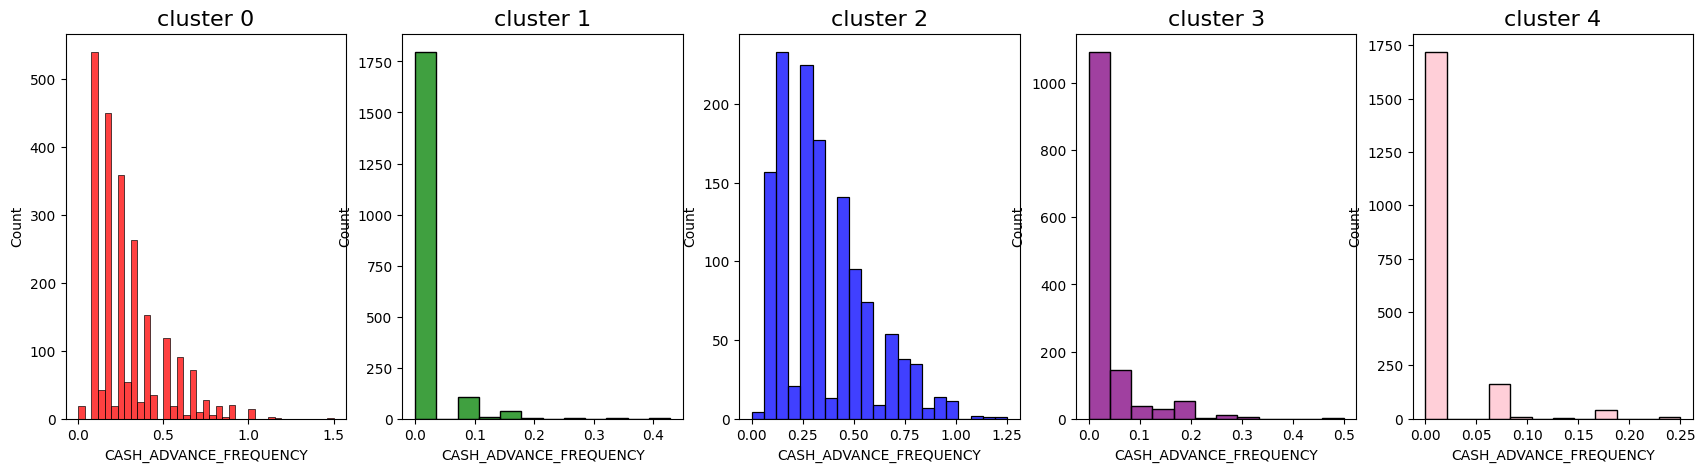

In [52]:
plt.figure(figsize=(21,5))
plt.subplot(1,5,1)
sns.histplot(cluster_0['CASH_ADVANCE_FREQUENCY'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,5,2)
sns.histplot(cluster_1['CASH_ADVANCE_FREQUENCY'], color='green')
plt.title('cluster 1', size = 16)
plt.subplot(1,5,3)
sns.histplot(cluster_2['CASH_ADVANCE_FREQUENCY'], color='blue')
plt.title('cluster 2', size = 16)
plt.subplot(1,5,4)
sns.histplot(cluster_3['CASH_ADVANCE_FREQUENCY'], color='purple')
plt.title('cluster 3', size = 16)
plt.subplot(1,5,5)
sns.histplot(cluster_4['CASH_ADVANCE_FREQUENCY'], color='pink')
plt.title('cluster 4', size = 16)
plt.show()

In [53]:
fig = go.Figure()

def cluster3d(cluster, color):
    fig.add_trace(go.Scatter3d(
        x=df[df.cluster_id == cluster]['ONEOFF_PURCHASES_FREQUENCY'],
        y=df[df.cluster_id == cluster]['PURCHASES_INSTALLMENTS_FREQUENCY'],
        z=df[df.cluster_id == cluster]['CASH_ADVANCE_FREQUENCY'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker_color=color,
        marker_size=5))


for C in list(df.cluster_id.unique()):
    if C == 0:
        cluster3d(0, 'red')
    elif C == 1:
        cluster3d(1, 'green')
    elif C == 2:
        cluster3d(2, 'blue')
    elif C == 3:
        cluster3d(3, 'purple')
    elif C == 4:
        cluster3d(3, 'purple')

fig.update_layout(height=900, width=1100,
                  scene=dict(
                      xaxis_title='ONEOFF_PURCHASES_FREQUENCY',
                      yaxis_title='PURCHASES_INSTALLMENTS_FREQUENCY',
                      zaxis_title='CASH_ADVANCE_FREQUENCY'),
                  title_text='A 3D Projection Of Data In The Reduced Dimension')
fig.show()

In [54]:
cluster_0[['BALANCE','PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].describe().T

count         mean          std        min  \
BALANCE                 2362.0  2292.987377  2047.640117  15.523256   
PURCHASES               2362.0    37.085804   127.838258   0.000000   
ONEOFF_PURCHASES        2362.0    34.636685   127.298842   0.000000   
INSTALLMENTS_PURCHASES  2362.0     2.500631    16.857760   0.000000   
CASH_ADVANCE            2362.0  2023.829911  2415.247911   0.000000   
CREDIT_LIMIT            2362.0  4120.817617  3248.575634  50.000000   
PAYMENTS                2362.0  1639.495991  2586.498418   0.000000   

                                25%          50%          75%          max  
BALANCE                  956.014165  1593.974084  2933.197546  14581.45914  
PURCHASES                  0.000000     0.000000     0.000000   1770.00000  
ONEOFF_PURCHASES           0.000000     0.000000     0.000000   1770.00000  
INSTALLMENTS_PURCHASES     0.000000     0.000000     0.000000    350.31000  
CASH_ADVANCE             412.574908  1297.647772  2747.594487  26194.04954  
CREDIT_LIMIT            1500.000000  3000.000000  6000.000000  19000.00000  
PAYMENTS                 397.545684   791.113474  1723.615091  34107.07499

**Cluster 0 - Behavior**
* Balance: Average balance is around 2,293, with most balances falling between 956 and 2,933. A few customers hold significantly higher balances.

* Purchases: Low purchase activity, with an average of 37 and median of $0. Most customers make no purchases.

* One-off Purchases: Similar pattern to purchases, with an average of 34 and most customers making no one-off purchases.

* Installments Purchases: Very low installment purchases, with an average of 2.50, and most customers making none.

* Cash Advance: High reliance on cash advances, with an average of 2,023. Many customers take out substantial amounts.

* Credit Limit: Average credit limit of 4,121, but wide variation from 50 to 19,000.

* Payments: Average payments of $1,639, but most customers make low payments relative to their balances.

**Key Insights**
* Low Purchase Activity: Most customers in this cluster are not making purchases, especially not one-off or installment purchases.

* High Cash Advance Usage: A large proportion of the balance and activity is in the form of cash advances, with many customers relying heavily on them.

* Moderate Credit Limits and Payments: Credit limits and payments vary widely. Some customers have high limits and make large payments, but the majority are making lower payments.

In [55]:
cluster_1[['BALANCE','PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].describe().T

count         mean          std    min          25%  \
BALANCE                 1958.0   408.129186   681.266839    0.0    31.554843   
PURCHASES               1958.0   594.022446   643.686094   12.0   237.300000   
ONEOFF_PURCHASES        1958.0    30.793381   103.984394    0.0     0.000000   
INSTALLMENTS_PURCHASES  1958.0   564.121083   638.580773   12.0   222.000000   
CASH_ADVANCE            1958.0    40.450529   193.747211    0.0     0.000000   
CREDIT_LIMIT            1958.0  2877.458317  2427.007174  300.0  1200.000000   
PAYMENTS                1958.0   743.871521   857.104492    0.0   262.833515   

                                50%          75%           max  
BALANCE                   91.618377   523.850027   8115.039014  
PURCHASES                420.300000   719.610000  12375.000000  
ONEOFF_PURCHASES           0.000000     0.000000   1212.870000  
INSTALLMENTS_PURCHASES   385.580000   666.525000  12375.000000  
CASH_ADVANCE               0.000000     0.000000   2158.502052  
CREDIT_LIMIT            2000.000000  4000.000000  21500.000000  
PAYMENTS                 496.271288   921.639368  15246.115940

**Cluster 1 - Behavior**
* Balance: The average balance is 408, with most balances under 524, indicating low balances overall. There are some outliers with higher balances.

* Purchases: The average purchases are 594, with most customers spending between 237 and 720. Some outliers have purchases up to 12,375.

* One-off Purchases: Very low one-off purchases with an average of 31, and most customers making no one-off purchases.

* Installments Purchases: High installment purchases with an average of 564, indicating that most customers prefer to make purchases in installments.

* Cash Advance: Minimal reliance on cash advances, with an average of 40 and most customers not using cash advances at all.

* Credit Limit: The average credit limit is 2,877, with a range from 300 to 21,500.

* ayments: Average payments of 744, with most customers making moderate payments between 263 and 922. Some outliers make large payments up to 15,246.
  
**Key Insights**

* Low Balance: Customers generally maintain low balances.
High Purchase Activity: Frequent card usage with significant purchase activity.

* Low One-off Purchases: Rarely make one-off purchases.

* High Installment Purchases: Significant use of installment options.

* Minimal Cash Advance Usage: Rarely use cash advances.

* Moderate Credit Limits: Credit limits are average, with wide variation.

* Moderate Payments: Regular but moderate payments.

In [56]:
cluster_2[['BALANCE','PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].describe().T

count         mean          std         min  \
BALANCE                 1312.0  3431.094550  2729.315709   32.779456   
PURCHASES               1312.0  1408.133552  1772.292659    4.440000   
ONEOFF_PURCHASES        1312.0   823.379512  1395.783873    0.000000   
INSTALLMENTS_PURCHASES  1312.0   584.998712   947.334841    0.000000   
CASH_ADVANCE            1312.0  2765.844902  3262.890633    0.000000   
CREDIT_LIMIT            1312.0  6001.905488  4022.649475  300.000000   
PAYMENTS                1312.0  3048.654374  4024.398454    0.000000   

                                25%          50%          75%          max  
BALANCE                 1361.662539  2667.411940  4859.617190  16304.88925  
PURCHASES                422.500000   860.895000  1663.832500  22101.78000  
ONEOFF_PURCHASES          70.000000   401.340000  1018.237500  22101.78000  
INSTALLMENTS_PURCHASES    65.000000   288.700000   750.450000  14686.10000  
CASH_ADVANCE             885.744695  1841.720461  3574.007722  47137.21176  
CREDIT_LIMIT            3000.000000  5000.000000  8500.000000  30000.00000  
PAYMENTS                 941.976948  1725.428813  3523.470481  40627.59524

**Cluster 2 - Behavior**
* High Balance: Customers maintain high average balances, averaging around 3,431. Many have balances reaching up to 16,305.

* High Purchase Activity: They make substantial purchases, averaging 1,408, with some customers spending as much as 22,102.

* High One-off Purchases: Frequent large one-off purchases, with an average of 823 and some up to 22,102.

* High Installment Purchases: Significant use of installment payments, averaging 585, with some reaching 14,686.

* High Cash Advance Usage: Heavy reliance on cash advances, averaging 2,766, and some customers take out amounts as high as 47,137.

* High Credit Limits: Average credit limits are high, averaging 6,002, with limits up to 30,000.

* High Payments: They make large payments, averaging 3,049, with some payments reaching 40,628.

**Key Insights:**

* Financial Flexibility: Customers in this cluster have high balances and credit limits, indicating financial flexibility and capacity for substantial transactions.

* Heavy Card Usage: They are active in using their credit cards for both large one-off and installment purchases, as well as cash advances.

* Strong Payment Behavior: Despite the high balances and large cash advances, these customers make significant payments, suggesting strong payment capabilities or strategies to manage their credit efficiently.

In [57]:
cluster_3[['BALANCE','PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].describe().T

count         mean          std    min          25%  \
BALANCE                 1373.0   296.454316   521.844756    0.0    10.684577   
PURCHASES               1373.0   329.811143   447.059603    0.0    53.000000   
ONEOFF_PURCHASES        1373.0   293.113467   455.059418    0.0     0.000000   
INSTALLMENTS_PURCHASES  1373.0    36.955834    83.897000    0.0     0.000000   
CASH_ADVANCE            1373.0   120.259710   406.453253    0.0     0.000000   
CREDIT_LIMIT            1372.0  3548.632167  3090.380970  150.0  1500.000000   
PAYMENTS                1373.0   769.244496  1783.332739    0.0   135.546054   

                                50%          75%           max  
BALANCE                   53.697916   308.542887   4181.216991  
PURCHASES                157.400000   426.920000   3950.000000  
ONEOFF_PURCHASES         101.970000   385.000000   3950.000000  
INSTALLMENTS_PURCHASES     0.000000    37.350000    632.000000  
CASH_ADVANCE               0.000000     0.000000   6523.780195  
CREDIT_LIMIT            2500.000000  5000.000000  23000.000000  
PAYMENTS                 343.102984   766.573245  29272.486070

**Cluster 3 - Behavior:**

* Low Balance: Customers maintain low balances, with an average of 296. Most balances are below 310.

* Moderate Purchase Activity: Average purchase amount is 330, with spending ranging from 53 to 3,950.

* Low One-off Purchases: One-off purchases average 293, but with a wide range, indicating some high-value transactions.

* Low Installment Purchases: Minimal installment purchases, averaging 37, with many customers making none.

* Low Cash Advance Usage: Average cash advance is 120, showing limited use of cash advances.

* Moderate Credit Limits: Average credit limit is 3,549, with a range from 150 to 23,000.

**Key Insights:**

* Low Utilization: Customers in this cluster have low average balances and minimal engagement in high-value purchases or cash advances.

* Limited High-Value Transactions: While some high-value purchases occur, most spending is moderate.

* Credit Limit Variation: Credit limits are relatively high compared to usage, indicating potential for increased card utilization.

* Potential for Increased Engagement: There is an opportunity to encourage more use of credit lines, especially for purchases and cash advances, given the low engagement with high-value transactions.

In [58]:
cluster_4[['BALANCE','PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].describe().T

count         mean          std         min  \
BALANCE                 1945.0  1479.829692  1919.462925    1.198223   
PURCHASES               1945.0  2790.585460  3659.122896    8.400000   
ONEOFF_PURCHASES        1945.0  1890.740602  2951.500599    0.000000   
INSTALLMENTS_PURCHASES  1945.0   899.918344  1469.339476    0.000000   
CASH_ADVANCE            1945.0    55.271454   290.329477    0.000000   
CREDIT_LIMIT            1945.0  6226.308587  4072.202225  300.000000   
PAYMENTS                1945.0  2635.804768  3593.870425    0.000000   

                                25%          50%          75%           max  
BALANCE                  281.170378   807.091888  1925.094714  19043.138560  
PURCHASES                991.480000  1842.640000  3224.340000  49039.570000  
ONEOFF_PURCHASES         540.000000  1100.000000  2165.120000  40761.250000  
INSTALLMENTS_PURCHASES    81.860000   460.800000  1148.400000  22500.000000  
CASH_ADVANCE               0.000000     0.000000     0.000000   7894.578816  
CREDIT_LIMIT            3000.000000  6000.000000  8000.000000  30000.000000  
PAYMENTS                 904.685540  1670.202477  3038.416025  50721.483360

**Cluster 4 - Behavior:**

* High Balance: Customers maintain high average balances, averaging 1,480, with many having balances up to 19,043.

* High Purchase Activity: Significant average purchases of 2,791, with some customers spending up to 49,040.

* High One-off Purchases: Average one-off purchases are substantial at 1,891, with a maximum of 40,761.

* High Installment Purchases: Significant average installment purchases of 900, with some as high as 22,500.

* Low Cash Advance Usage: Minimal average cash advance of 55, with limited usage overall.

* High Credit Limits: Average credit limit is high at 6,226, with limits ranging up to 30,000.

* High Payments: High average payments of 2,636, with some payments reaching  50,721.

**Key Insights:**

* High Engagement: Cluster 4 customers show high engagement with their credit cards, including substantial balances, large purchases, and significant installment payments.
* Heavy Use of Credit Facilities: They utilize their credit cards extensively for both one-off and installment purchases, though they rarely use cash advances.
* Strong Financial Capability: They have high credit limits and make large payments, indicating robust financial activity and a strong capacity to manage their credit.

# 7 . Summary and Recommendations

##Cluster 0:

**Summary:**
Customers maintain moderate balances and make low purchases, with a heavy reliance on cash advances. They have moderate credit limits and make moderate payments.

**Recommendations:**
* Promote Balance Management: Encourage customers to use their credit line more efficiently by offering tools for balance tracking and alerts.
* Incentivize Purchases: Provide promotions or rewards to increase purchase activity, especially for one-off and installment purchases.
* Manage Cash Advances: Introduce incentives or educational content about managing cash advances and alternative options.

##Cluster 1:

**Summary:** Customers have low balances and credit limits, but high purchase activity, particularly with installment purchases. They rarely use cash advances and make moderate payments.

**Recommendations:**
* Offer Higher Credit Limits: Consider increasing credit limits for these customers to enhance their purchasing power.
* Encourage One-off Purchases: Develop targeted offers or rewards to incentivize one-off purchases.
* Promote Financial Management Tools: Offer tools or advice to help manage and optimize credit card use.

##Cluster 2:
**Summary:**
 Customers have high balances and credit limits, with substantial purchase and installment activity. They make significant cash advances and payments.

**Recommendations:**
Tailor Premium Services: Offer premium services or exclusive rewards to match their high engagement and spending levels.
Optimize Cash Advance Options: Provide personalized cash advance offers or strategies to manage large transactions.
Enhance Financial Planning Tools: Offer advanced financial management tools to help them manage their high credit utilization and payments effectively.

##Cluster 3:
**Summary:**
 Customers maintain low balances with minimal purchase activity and cash advances. Their credit limits are moderate, and they make low payments.

**Recommendations:**
Increase Engagement: Develop strategies to increase card usage, such as targeted promotions or educational campaigns about benefits.
Encourage Higher Usage: Provide incentives for larger transactions or more frequent use of credit facilities.
Review Credit Limits: Assess the appropriateness of their credit limits and consider adjustments based on increased engagement.

##Cluster 4:
**Summary:** Customers exhibit high balances and credit limits with substantial purchase and installment activity. They have high payments and minimal cash advance use.

**Recommendations:**
* Leverage High Engagement: Offer exclusive rewards or benefits to further enhance their engagement.
* Promote Balanced Usage: Encourage a balanced approach to credit utilization, ensuring they maximize benefits across all areas of card use.
* Personalized Financial Advice: Provide personalized financial planning and advisory services to optimize their credit card usage and manage large transactions effectively.